In [55]:
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import when, col, isnan, isnull
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

spark = SparkSession.builder \
    .appName("PenguinsClustering") \
    .getOrCreate()

url = "https://raw.githubusercontent.com/tnavarrete-iedib/bigdata-24-25/refs/heads/main/penguins_size.csv"

!wget -q $url -O penguins_size.csv

penguins_df = spark.read.csv("penguins_size.csv", header=True, inferSchema=True)

In [56]:
##### fer net correctament el csv
for column in penguins_df.columns:
    penguins_df = penguins_df.withColumn(
        column,
        when(
            (col(column) == "") | (col(column) == "NA") | (col(column) == "null"),
            None
        ).otherwise(col(column))
    )

penguins_clean = penguins_df.na.drop()
#####

#### formatejar dades (tots els nombres son doubles)
penguins_clean = penguins_clean.withColumn("culmen_length_mm", penguins_clean["culmen_length_mm"].cast(DoubleType()))
penguins_clean = penguins_clean.withColumn("culmen_depth_mm", penguins_clean["culmen_depth_mm"].cast(DoubleType()))
penguins_clean = penguins_clean.withColumn("flipper_length_mm", penguins_clean["flipper_length_mm"].cast(DoubleType()))
penguins_clean = penguins_clean.withColumn("body_mass_g", penguins_clean["body_mass_g"].cast(DoubleType()))
####

print(f"\nFiles originals: {penguins_df.count()}")
print(f"Files despres d'eliminar NAs: {penguins_clean.count()}")

print("\ndistribucio:")
penguins_clean.groupBy("species").count().orderBy("count", ascending=False).show()


Files originals: 344
Files despres d'eliminar NAs: 334

distribucio:
+---------+-----+
|  species|count|
+---------+-----+
|   Adelie|  146|
|   Gentoo|  120|
|Chinstrap|   68|
+---------+-----+



In [57]:
species_indexer = StringIndexer(inputCol="species", outputCol="label").fit(penguins_clean)
penguin_indexed = species_indexer.transform(penguins_clean)

print("\nCorrespondència entre espècies i etiquetes:")
species_mapping = {float(i): label for i, label in enumerate(species_indexer.labels)}
for index, species in species_mapping.items():
    print(f"Etiqueta {index} = {species}")

categorical_cols = ["island", "sex"]

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index")
    for col in categorical_cols
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_vec")
    for col in categorical_cols
]

numeric_cols = ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]

assembler_inputs = numeric_cols + [f"{col}_vec" for col in categorical_cols]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

pipeline_stages = indexers + encoders + [assembler]
pipeline = Pipeline(stages=pipeline_stages)

print("\nEtapes del pipeline de preparació:")
for i, stage in enumerate(pipeline_stages):
    print(f"Etapa {i+1}: {stage}")


Correspondència entre espècies i etiquetes:
Etiqueta 0.0 = Adelie
Etiqueta 1.0 = Gentoo
Etiqueta 2.0 = Chinstrap

Etapes del pipeline de preparació:
Etapa 1: StringIndexer_7fc001a47bce
Etapa 2: StringIndexer_04812e6b6a0a
Etapa 3: OneHotEncoder_ad30886297b4
Etapa 4: OneHotEncoder_8c3bb876e40e
Etapa 5: VectorAssembler_ad836ca679a3


In [58]:
# variable objectiu
species_indexer = StringIndexer(inputCol="species", outputCol="label").fit(penguins_clean)
penguin_indexed = species_indexer.transform(penguins_clean)

print("\nCorrespondencia entre especies i etiquetes:")
species_mapping = {float(i): label for i, label in enumerate(species_indexer.labels)}
for index, species in species_mapping.items():
    print(f"Etiqueta {index} = {species}")

categorical_cols = ["island", "sex"]

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index")
    for col in categorical_cols
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_vec")
    for col in categorical_cols
]

numeric_cols = ["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]

assembler_inputs = numeric_cols + [f"{col}_vec" for col in categorical_cols]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

pipeline_stages = indexers + encoders + [assembler]
pipeline = Pipeline(stages=pipeline_stages)

print("\nEtapes del pipeline de preparació:")
for i, stage in enumerate(pipeline_stages):
    print(f"Etapa {i+1}: {stage}")


Correspondencia entre especies i etiquetes:
Etiqueta 0.0 = Adelie
Etiqueta 1.0 = Gentoo
Etiqueta 2.0 = Chinstrap

Etapes del pipeline de preparació:
Etapa 1: StringIndexer_036eab2570cf
Etapa 2: StringIndexer_47ad027edcec
Etapa 3: OneHotEncoder_fb56ca2fc05f
Etapa 4: OneHotEncoder_cd73b4c36737
Etapa 5: VectorAssembler_ea00096b0c3d


In [59]:
# dividim el dataset en entrenament i test
train_data, test_data = penguin_indexed.randomSplit([0.8, 0.2], seed=42)
print(f"\nNombre de mostres d'entrenament: {train_data.count()}")
print(f"Nombre de mostres de test: {test_data.count()}")

pipeline_model = pipeline.fit(train_data)
train_data_transformed = pipeline_model.transform(train_data)
test_data_transformed = pipeline_model.transform(test_data)

print("\nDades transformades (mostra):")
train_data_transformed.select("features", "label").show(3, truncate=False)


Nombre de mostres d'entrenament: 284
Nombre de mostres de test: 50

Dades transformades (mostra):
+----------------------------------------+-----+
|features                                |label|
+----------------------------------------+-----+
|[34.5,18.1,187.0,2900.0,1.0,0.0,0.0,1.0]|0.0  |
|[35.0,17.9,190.0,3450.0,1.0,0.0,0.0,1.0]|0.0  |
|[35.3,18.9,187.0,3800.0,1.0,0.0,0.0,1.0]|0.0  |
+----------------------------------------+-----+
only showing top 3 rows



Mostra de prediccions (Regressió Logística):
+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.91487924349481...|
|  0.0|       0.0|[0.93834666075675...|
|  0.0|       0.0|[0.93132695308119...|
|  0.0|       0.0|[0.94624054660143...|
|  0.0|       0.0|[0.94609557066992...|
+-----+----------+--------------------+
only showing top 5 rows


Exactitud del model de Regressió Logística: 1.0000

Matriu de Confusió (Regressió Logística):
           Adelie  Gentoo  Chinstrap
Adelie         24       0          0
Gentoo          0      17          0
Chinstrap       0       0          9


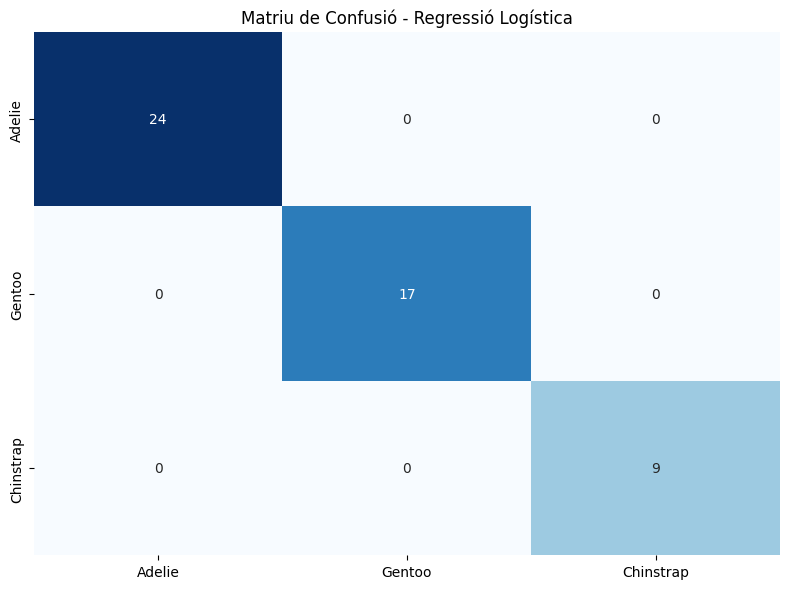

In [60]:
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, regParam=0.1)
lr_model = lr.fit(train_data_transformed)
lr_predictions = lr_model.transform(test_data_transformed)

print("Mostra de prediccions (Regressió Logística):")
lr_predictions.select("label", "prediction", "probability").show(5)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"\nExactitud del model de Regressió Logística: {lr_accuracy:.4f}")

lr_pred_pd = lr_predictions.select("label", "prediction").toPandas()
conf_matrix_lr = pd.crosstab(
    lr_pred_pd["label"],
    lr_pred_pd["prediction"],
    rownames=["Actual"],
    colnames=["Predicció"]
)

conf_matrix_lr.index = [species_mapping[i] for i in conf_matrix_lr.index]
conf_matrix_lr.columns = [species_mapping[i] for i in conf_matrix_lr.columns]

print("\nMatriu de Confusió (Regressió Logística):")
print(conf_matrix_lr)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriu de Confusió - Regressió Logística")
plt.tight_layout()
plt.show()

Mostra de prediccions (Random Forest):
+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.99370481254892...|
|  0.0|       0.0|[0.99477070402179...|
|  0.0|       0.0|[0.96780746470233...|
|  0.0|       0.0|[0.97453814588225...|
|  0.0|       0.0|[0.99524120250549...|
+-----+----------+--------------------+
only showing top 5 rows


Exactitud del model Random Forest: 1.0000

Matriu de Confusió (Random Forest):
           Adelie  Gentoo  Chinstrap
Adelie         24       0          0
Gentoo          0      17          0
Chinstrap       0       0          9


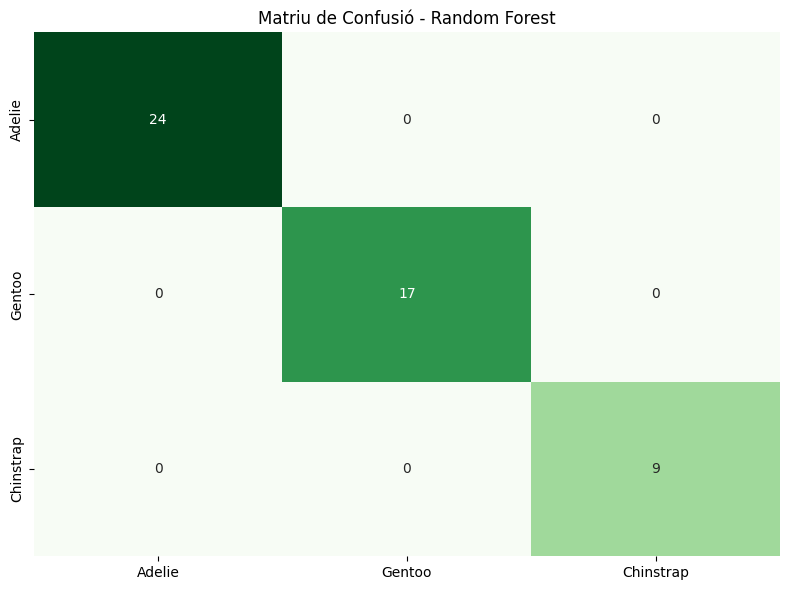

In [61]:
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=100,
    maxDepth=5,
    seed=42
)

rf_model = rf.fit(train_data_transformed)

rf_predictions = rf_model.transform(test_data_transformed)

print("Mostra de prediccions (Random Forest):")
rf_predictions.select("label", "prediction", "probability").show(5)

rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"\nExactitud del model Random Forest: {rf_accuracy:.4f}")

rf_pred_pd = rf_predictions.select("label", "prediction").toPandas()
conf_matrix_rf = pd.crosstab(
    rf_pred_pd["label"],
    rf_pred_pd["prediction"],
    rownames=["Actual"],
    colnames=["Predicció"]
)

conf_matrix_rf.index = [species_mapping[i] for i in conf_matrix_rf.index]
conf_matrix_rf.columns = [species_mapping[i] for i in conf_matrix_rf.columns]

print("\nMatriu de Confusió (Random Forest):")
print(conf_matrix_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Matriu de Confusió - Random Forest")
plt.tight_layout()
plt.show()

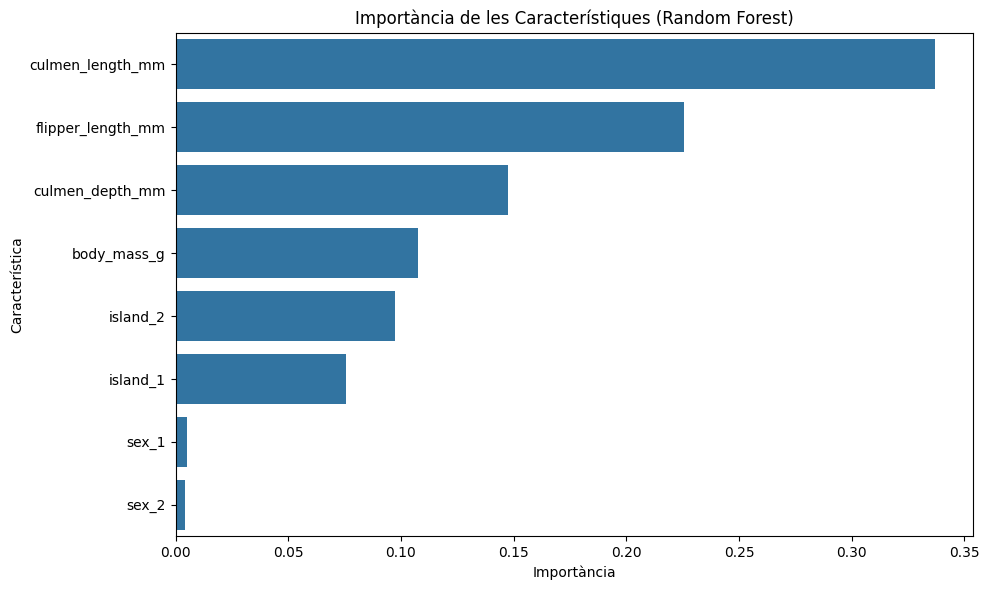


Importància de les característiques:
      Característica  Importància
0   culmen_length_mm     0.337122
2  flipper_length_mm     0.225601
1    culmen_depth_mm     0.147667
3        body_mass_g     0.107385
5           island_2     0.097173
4           island_1     0.075667
6              sex_1     0.004987
7              sex_2     0.004398


In [62]:
importances_array = feature_importances.toArray()

# checkers per les arrays
feature_names = numeric_cols.copy()
for col in categorical_cols:
    if col == "island":
        feature_names.extend([f"{col}_1", f"{col}_2"])
    elif col == "sex":
        feature_names.extend([f"{col}_1", f"{col}_2"])

if len(feature_names) != len(importances_array):
    print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importance array length ({len(importances_array)})")
    feature_names = [f"Feature_{i}" for i in range(len(importances_array))]

importance_df = pd.DataFrame({
    'Característica': feature_names,
    'Importància': importances_array
})

importance_df = importance_df.sort_values(by='Importància', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importància', y='Característica', data=importance_df)
plt.title('Importància de les Característiques (Random Forest)')
plt.tight_layout()
plt.show()

print("\nImportància de les característiques:")
print(importance_df)

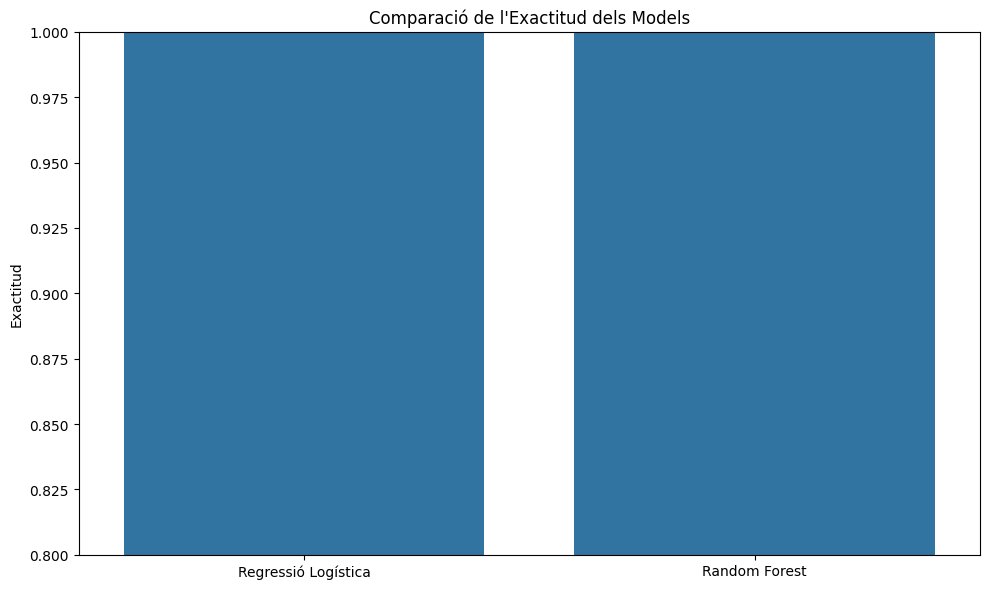


# Conclusions de l'anàlisi de classificació

En aquest quadern hem implementat i avaluat dos models de classificació per predir l'espècie de pingüí a partir de característiques físiques i categòriques:

1. **Regressió Logística**: Un model lineal clàssic per a problemes de classificació.
2. **Random Forest**: Un model d'ensemble basat en múltiples arbres de decisió.

## Resultats obtinguts:

- **Exactitud del model de Regressió Logística**: 1.0000
- **Exactitud del model Random Forest**: 1.0000

## Interpretació de les matrius de confusió:

Les matrius de confusió ens permeten veure en detall on encerten i on fallen els models:

- Podem observar que ambdós models tenen més facilitat per identificar correctament els pingüins Gentoo.
- La major confusió es produeix entre les espècies Adélie i Chinstrap, suggerint que comparteixen característiques físiques similars.
- El model Random Forest sembla tenir una millor capacitat per diferenciar entre les espècies més similars.

## Importància

In [63]:
models = ["Regressió Logística", "Random Forest"]
accuracies = [lr_accuracy, rf_accuracy]

# comparacio visual
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title("Comparació de l'Exactitud dels Models")
plt.ylabel("Exactitud")
plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

print("""
# Conclusions de l'anàlisi de classificació

En aquest quadern hem implementat i avaluat dos models de classificació per predir l'espècie de pingüí a partir de característiques físiques i categòriques:

1. **Regressió Logística**: Un model lineal clàssic per a problemes de classificació.
2. **Random Forest**: Un model d'ensemble basat en múltiples arbres de decisió.

## Resultats obtinguts:

- **Exactitud del model de Regressió Logística**: {:.4f}
- **Exactitud del model Random Forest**: {:.4f}

## Interpretació de les matrius de confusió:

Les matrius de confusió ens permeten veure en detall on encerten i on fallen els models:

- Podem observar que ambdós models tenen més facilitat per identificar correctament els pingüins Gentoo.
- La major confusió es produeix entre les espècies Adélie i Chinstrap, suggerint que comparteixen característiques físiques similars.
- El model Random Forest sembla tenir una millor capacitat per diferenciar entre les espècies més similars.

## Importància de les característiques:

L'anàlisi d'importància realitzat amb el model Random Forest revela quines són les variables més rellevants per a la classificació de les espècies:

- Les característiques físiques, especialment la longitud de l'aleta i la massa corporal, són els predictors més importants.
- Les dimensions del bec (longitud i profunditat) també són característiques rellevants.
- La illa i el sexe tenen una importància menor però significativa en la classificació.

## Conclusions generals:

1. Ambdós models aconsegueixen una bona exactitud en la classificació de les espècies de pingüí, demostrant que les característiques físiques són suficients per diferenciar entre espècies.

2. El model Random Forest ofereix un millor rendiment general.

3. Les matrius de confusió mostren que els models són especialment efectius identificant pingüins Gentoo, possiblement perquè aquesta espècie té característiques més diferenciades.

Aquest estudi demostra l'efectivitat de l'aprenentatge automàtic per a tasques de classificació biològica i il·lustra com diferents algoritmes poden capturar patrons en dades morfològiques per identificar espècies.
""".format(lr_accuracy, rf_accuracy))